<a href="https://colab.research.google.com/github/Aaaaarin/Sound-Refine/blob/main/Aarin_230013_task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls Sound-Refine


README.md  Task1  Task2  Task3	Task4


In [ ]:
!ls Sound-Refine/Task4


Arnav_Gupta_Task4.ipynb  Joel_230509_Task4.ipynb  Shaurya_Johari_230959_Task4.ipynb
Instructions.md		 membrane


In [ ]:
!ls Sound-Refine/Task4/membrane


Anurag_Sai_231138_task4.ipynb  test  test-volume.tif  train  train-labels.tif  train-volume.tif


In [ ]:
!ls Sound-Refine/Task4/membrane/train
!ls Sound-Refine/Task4/membrane/test


aug  image  label
image  label


Epoch 1/5
14/14 [==============================] - 146s 10s/step - loss: 0.6214 - accuracy: 0.7776 - val_loss: 0.5618 - val_accuracy: 0.7663
Epoch 2/5
14/14 [==============================] - 146s 10s/step - loss: 0.5198 - accuracy: 0.7819 - val_loss: 0.5273 - val_accuracy: 0.7663
Epoch 3/5
14/14 [==============================] - 143s 10s/step - loss: 0.5012 - accuracy: 0.7819 - val_loss: 0.5075 - val_accuracy: 0.7663
Epoch 4/5
14/14 [==============================] - 143s 10s/step - loss: 0.4801 - accuracy: 0.7819 - val_loss: 0.4804 - val_accuracy: 0.7663
Epoch 5/5
1/1 [==============================] - 42s 42s/step - loss: -428.4002 - accuracy: 7.4259e-05
Test Loss: -428.40020751953125, Test Accuracy: 7.425944204442203e-05


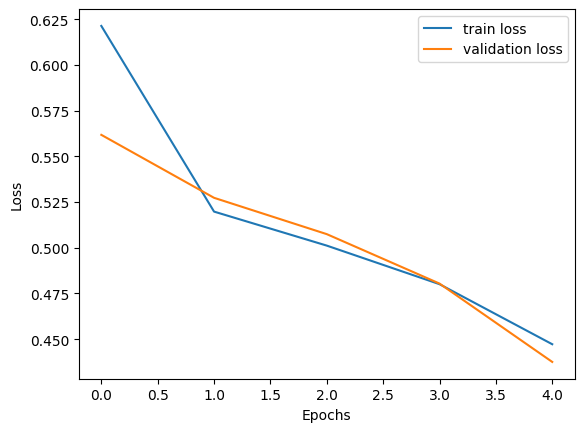

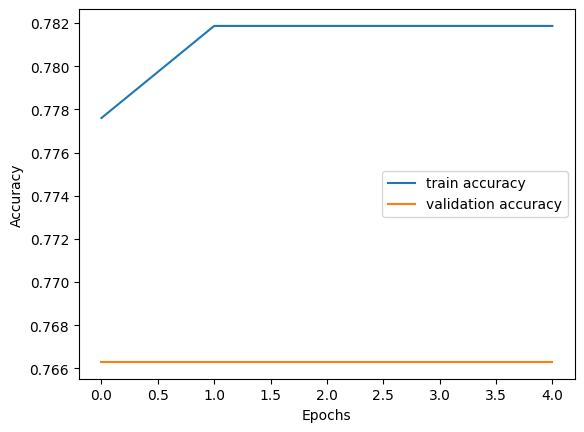

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

# Adjust paths and image size
base_path = 'Sound-Refine/Task4/membrane'
X_train_loc = f'{base_path}/train/image/'
Y_train_loc = f'{base_path}/train/label/'
X_test_loc = f'{base_path}/test/image/'
Y_test_loc = f'{base_path}/test/label/'

# Function to load dataset with resized images
def load_dataset(image_path, mask_path, target_size=(256, 256)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_path))
    mask_files = sorted(os.listdir(mask_path))

    for img_file, mask_file in zip(image_files, mask_files):
        img = load_img(os.path.join(image_path, img_file), color_mode="grayscale", target_size=target_size)
        img = img_to_array(img) / 255.0
        mask = load_img(os.path.join(mask_path, mask_file), color_mode="grayscale", target_size=target_size)
        mask = img_to_array(mask) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load resized dataset
train_images, train_masks = load_dataset(X_train_loc, Y_train_loc, target_size=(256, 256))
test_images, test_masks = load_dataset(X_test_loc, Y_test_loc, target_size=(256, 256))

# Define U-Net model with smaller image size
def build_unet(input_shape=(256, 256, 1)):
    inputs = Input(shape=input_shape)

    def conv_block(x, filters, kernel_size=3, activation='relu', padding='same'):
        x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
        x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
        return x

    def encoder_block(x, filters):
        x = conv_block(x, filters)
        p = MaxPooling2D(pool_size=(2, 2))(x)
        return x, p

    def decoder_block(x, skip, filters):
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(filters, 2, activation='relu', padding='same')(x)
        x = concatenate([x, skip], axis=3)
        x = conv_block(x, filters)
        return x

    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    c5 = conv_block(p4, 1024)

    u6 = decoder_block(c5, c4, 512)
    u7 = decoder_block(u6, c3, 256)
    u8 = decoder_block(u7, c2, 128)
    u9 = decoder_block(u8, c1, 64)

    outputs = Conv2D(1, 1, activation='sigmoid')(u9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build and train model with reduced batch size
model = build_unet()
history = model.fit(train_images, train_masks, epochs=5, batch_size=2, validation_split=0.1)

# Evaluate model
loss, accuracy = model.evaluate(test_images, test_masks)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
